# Домашнее задание №3
Домашнее задание включает в себя следующие пункты:
1. Написать собственную свертку
2. Написать модуль батч нормализации для картинок
3. Написать модули для оптимизации SGD+momentum, Adam
4. Построить графики и обучения и сделать выводы по сравнению обучения 
    * SGD+momentum, Adam
    
Адрес для посылки ДЗ mfti_2018_hw03@mail.ru

# Требуемые модули:
Python 3.6
1. pytorch=0.41 // [инструкция по установке](https://pytorch.org/get-started/previous-versions/)
2. torchvision=0.2.2.post3 // pip install ...
3. matplotlib  //
4. PIL=5.4.1
5. scipy=1.1.0
6. numpy=1.15.14
7. pickle

# Требования
1. Присылаем этот ноутбук только с полностью выполненными заданиями.
2. Файл должен называть MFTI_2019_hw03_ФАМИЛИЯ_ИМЯ.ipynb
3. Заданние должно быть выполнено до 24.03.2019 до 23:59.
4. После проверки у Вас будет одна попытка для исправления замечаний. 

# 1. Реализация собственной свертки
В этом пункте Вам нужно реализовать модуль необучаемой свертки 2D. Используем только библиотеку <font collor='red'>__pytorch__</font>. Получаем на вход тензор размером $(C_{in}, H, W)$, на выходе получаем тензор $(C_{out}, H_{out}, W_{out})$.
$$
H - высота. \\
W - ширина. \\
С - количество\ каналов \\
$$
Реализуем операцию свертки с параметрами:

$\large k $ - ядро свертки, тензор с парамерами $C_{in}, H_k, W_k,$ <br>
$stride_{H,W}$ - шаг ядра свертки, <br>
$padding_{H,W} $ - размер паддинга.

Формулы расчета размера выходной картинки
$$
\begin{align}\begin{aligned}H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}_H- \text{kernel_size}_H}{\text{stride}_H} + 1\right\rfloor\\W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}_W - \text{kernel_size}_W}{\text{stride}_W} + 1\right\rfloor\end{aligned}\end{align}
$$
Графическое представление 2D свертки
### Представление свертки
Параметры: kernel=3x3, padding=0,0
<img src="./imgs/18.jpg">

### Stride
Параметры: kernel=2x2, padding=0,0, stride=2,2
<img src="./imgs/22.gif" width=300>

### Padding
Параметры: kernel=2x2, padding=1,1, stride=1,1
<img src="./imgs/23.gif" width=400>



### Для проверки работоспособности сверки можно использовать 

```python 
from torch.nn.functional import conv2d
```
### Добавление дополнительной размерности в тензор
B - размер батча в нашем случае 1, размер картинки $C\times H \times W$. Для добавления и схлопывания размерностей используем
  - squeeze() - убирает размерность
  - unsqueeze() - добавляет размерность

In [29]:
# прототип функции 
import math as m
def my_conv2d(x,
              kernel,
              stride=(1,1), padding=(0,0), bias=None):
    """
    Arguments:
    :param  x: входной тензор 4d, тип tensor.FloatTensor, размерность BxCxHxW
    :param  kernel: входной тензор ядра 3d, тип tensor.FloatTensor, CxHxW
    :param  stride: tuple - параметры страйда, задаются в формате HxW
    :param  padding:  tuple - параметры паддинга, задаются в формате HxW
    :param  bias : входной тензор bias добавляется к выходному тензору.  
    """
    h_out = m.floor(1 + (int(x.size()[1]) + 2*padding[0] - kernel.size()[1])/stride[0])
    w_out = m.floor(1 + (int(x.size()[2]) + 2*padding[1] - kernel.size()[2])/stride[1])
    x_out = torch.zeros(x.size()[0],h_out, w_out) 
    temp_tens = torch.zeros(kernel.size())
    temp = 0
    h, v = -1 , -1

    x = torch.cat((x, torch.zeros(x.size()[0], padding[0], x.size()[2])), 1)
    x = torch.cat((x, torch.zeros(x.size()[0], x.size()[1], padding[1])), 2)
    x = torch.cat((torch.zeros(x.size()[0], x.size()[1], padding[1]), x), 2)
    x = torch.cat((torch.zeros(x.size()[0], padding[0], x.size()[2]), x), 1)
    
    for i in range(0, x.size()[1] - kernel.size()[1]  + 1, stride[0]):
        h += 1
        v = -1
        for j in range(0, x.size()[2] - kernel.size()[2] + 1, stride[1]):
            v += 1
            temp_tens = x[:, i:i+kernel.size()[1], j:j+kernel.size()[2]] * kernel
            temp = temp_tens.sum()
            x_out[:,h, v] = temp
    return x_out[0]

In [30]:
# функции тестирования
from tests_functions import * 

### Загружаем картинку 

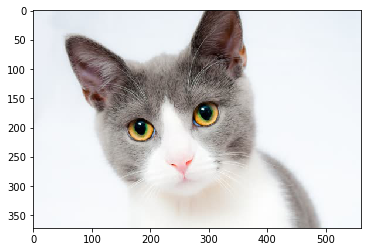

In [31]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [32]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [33]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


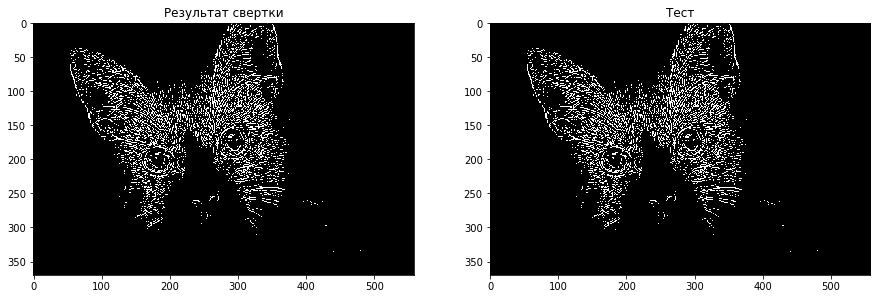

In [34]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_01.pth')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [7]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


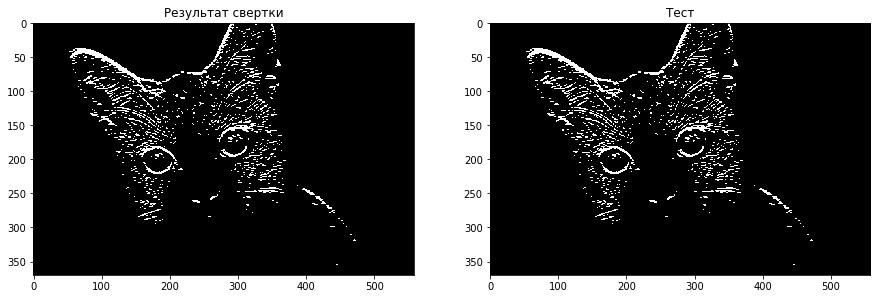

In [8]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_02.pth')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [39]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


AssertionError: Что-то пошло не так, тест не пройден

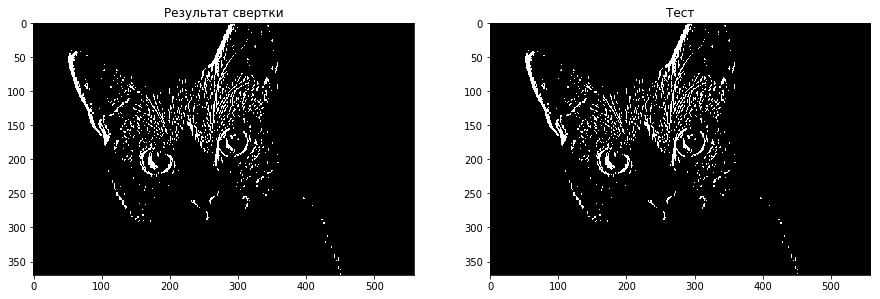

In [40]:
o_image = my_conv2d(cat_tensor, filter_kernel)
o_image[o_image >= 0.5] = 1  # бустим границы
o_image[o_image < 0.5] = 0
test_conv(o_image, './data/kernel_03.pth')

In [41]:
cat = torch.load('./data/kernel_03.pth')
o_image = my_conv2d(cat_tensor, filter_kernel)
for i in range(o_image.size()[0]):
    for j in range(o_image.size()[1]):
        if int(cat[i][j]) != int(o_image[i][j]):
            print( i, j)

0 289
0 291
0 292
0 293
0 339
0 340
0 347
0 348
0 349
0 350
1 291
1 292
1 293
1 339
1 348
1 349
1 350
1 351
2 288
2 290
2 291
2 292
2 348
2 349
2 350
2 351
3 289
3 290
3 291
3 292
3 348
3 349
3 350
3 351
4 287
4 289
4 290
4 291
4 295
4 298
4 343
4 348
4 349
4 350
4 351
4 352
5 286
5 288
5 289
5 290
5 291
5 295
5 343
5 344
5 348
5 349
5 350
5 351
5 352
6 289
6 290
6 291
6 296
6 344
6 348
6 349
6 350
6 351
6 352
7 287
7 290
7 291
7 297
7 299
7 344
7 347
7 350
7 351
7 352
8 285
8 286
8 287
8 290
8 293
8 294
8 299
8 345
8 347
8 350
8 351
8 352
8 353
9 286
9 287
9 290
9 293
9 345
9 350
9 351
9 352
9 353
10 284
10 286
10 287
10 290
10 291
10 292
10 293
10 294
10 295
10 297
10 315
10 345
10 350
10 351
10 352
10 353
11 285
11 286
11 287
11 288
11 290
11 291
11 294
11 296
11 348
11 349
11 351
11 352
11 353
12 283
12 285
12 286
12 287
12 288
12 296
12 348
12 349
12 351
12 352
12 353
12 354
13 285
13 286
13 287
13 288
13 290
13 296
13 334
13 335
13 346
13 348
13 351
13 352
13 353
13 354
14 282
14

77 274
77 275
77 276
77 278
77 279
77 284
77 288
77 313
77 322
77 323
77 363
77 364
78 58
78 59
78 60
78 118
78 119
78 128
78 138
78 140
78 142
78 145
78 146
78 147
78 148
78 149
78 247
78 248
78 249
78 254
78 255
78 257
78 262
78 270
78 273
78 274
78 279
78 294
78 320
78 321
78 352
78 353
78 363
78 364
78 365
79 57
79 58
79 59
79 60
79 127
79 128
79 138
79 140
79 142
79 144
79 145
79 146
79 147
79 148
79 149
79 247
79 248
79 254
79 255
79 257
79 258
79 261
79 262
79 271
79 273
79 277
79 279
79 294
79 299
79 303
79 311
79 314
79 321
79 352
79 353
79 363
79 364
79 365
80 59
80 60
80 63
80 64
80 128
80 129
80 138
80 146
80 147
80 148
80 149
80 150
80 246
80 247
80 248
80 254
80 258
80 261
80 262
80 265
80 266
80 273
80 277
80 278
80 294
80 299
80 302
80 303
80 314
80 315
80 317
80 341
80 342
80 352
80 353
80 363
80 364
80 365
81 59
81 60
81 62
81 64
81 134
81 144
81 147
81 148
81 149
81 150
81 151
81 152
81 246
81 247
81 248
81 262
81 265
81 266
81 272
81 275
81 277
81 280
81 302
81 307


105 157
105 158
105 199
105 213
105 231
105 242
105 248
105 262
105 263
105 266
105 268
105 271
105 277
105 281
105 287
105 288
105 296
105 302
105 303
105 308
105 309
105 321
105 322
105 336
105 340
105 341
105 342
105 353
105 354
105 355
105 356
105 357
105 358
105 359
106 67
106 68
106 69
106 72
106 73
106 118
106 138
106 139
106 140
106 158
106 176
106 213
106 230
106 242
106 261
106 262
106 263
106 267
106 268
106 280
106 281
106 285
106 286
106 296
106 303
106 308
106 309
106 311
106 313
106 316
106 319
106 321
106 322
106 339
106 340
106 341
106 353
106 354
106 355
106 356
107 67
107 73
107 117
107 165
107 166
107 181
107 182
107 213
107 230
107 235
107 242
107 243
107 263
107 265
107 267
107 270
107 272
107 274
107 275
107 280
107 281
107 284
107 286
107 288
107 291
107 296
107 303
107 308
107 309
107 310
107 311
107 313
107 315
107 316
107 318
107 321
107 322
107 339
107 341
107 353
107 355
107 356
108 115
108 129
108 165
108 177
108 181
108 182
108 184
108 204
108 205
108 223

129 280
129 281
129 282
129 283
129 287
129 288
129 293
129 294
129 295
129 301
129 302
129 317
129 320
129 332
130 83
130 86
130 102
130 119
130 120
130 121
130 122
130 123
130 127
130 149
130 155
130 156
130 173
130 174
130 178
130 180
130 184
130 199
130 216
130 219
130 229
130 235
130 241
130 256
130 257
130 261
130 264
130 265
130 266
130 267
130 270
130 272
130 273
130 275
130 282
130 293
130 311
130 315
130 319
130 323
130 332
130 336
130 337
131 85
131 86
131 87
131 102
131 118
131 119
131 149
131 150
131 156
131 158
131 159
131 171
131 175
131 177
131 179
131 184
131 199
131 202
131 216
131 219
131 220
131 228
131 241
131 256
131 257
131 259
131 261
131 266
131 272
131 275
131 276
131 281
131 282
131 286
131 293
131 310
131 315
131 316
131 319
131 322
131 323
131 335
131 336
131 337
132 81
132 83
132 86
132 88
132 118
132 128
132 149
132 153
132 159
132 170
132 175
132 179
132 180
132 183
132 187
132 192
132 199
132 202
132 203
132 207
132 211
132 214
132 220
132 223
132 228
1

154 244
154 260
154 262
154 264
154 266
154 273
154 281
154 288
154 293
154 294
154 317
154 318
154 336
155 89
155 93
155 99
155 100
155 102
155 103
155 108
155 121
155 128
155 129
155 154
155 167
155 177
155 178
155 184
155 185
155 188
155 192
155 203
155 217
155 220
155 222
155 224
155 225
155 230
155 233
155 259
155 262
155 286
155 288
155 293
155 294
155 334
156 90
156 98
156 99
156 100
156 101
156 102
156 103
156 107
156 108
156 109
156 121
156 122
156 128
156 129
156 138
156 151
156 167
156 179
156 180
156 188
156 195
156 196
156 203
156 220
156 224
156 225
156 233
156 239
156 259
156 260
156 263
156 269
156 270
156 281
156 285
156 334
157 91
157 94
157 99
157 100
157 101
157 102
157 109
157 110
157 121
157 122
157 128
157 129
157 130
157 138
157 139
157 142
157 167
157 180
157 183
157 185
157 188
157 189
157 194
157 195
157 201
157 203
157 218
157 220
157 225
157 239
157 252
157 258
157 259
157 263
157 269
157 270
157 277
157 282
157 285
157 287
157 331
157 334
158 95
158 100
15

181 118
181 119
181 155
181 156
181 165
181 166
181 172
181 173
181 209
181 245
181 246
181 247
181 260
181 261
181 270
181 271
181 274
181 275
181 276
181 277
181 282
181 284
181 286
181 287
181 288
181 301
181 302
181 303
181 305
181 306
181 307
181 308
181 313
181 314
181 317
181 318
181 319
181 325
181 326
181 331
182 118
182 119
182 155
182 166
182 173
182 191
182 212
182 214
182 246
182 247
182 260
182 270
182 271
182 274
182 275
182 276
182 277
182 283
182 284
182 285
182 287
182 288
182 289
182 301
182 302
182 303
182 305
182 306
182 307
182 312
182 317
182 318
182 325
182 326
182 331
182 337
183 119
183 120
183 121
183 122
183 152
183 162
183 166
183 172
183 173
183 177
183 187
183 188
183 191
183 192
183 212
183 214
183 246
183 247
183 255
183 270
183 271
183 274
183 275
183 276
183 277
183 278
183 283
183 284
183 285
183 288
183 290
183 300
183 301
183 302
183 304
183 305
183 306
183 311
183 312
183 316
183 317
183 318
183 324
183 325
183 330
183 331
183 336
183 337
184 119


217 305
217 338
217 348
217 350
218 110
218 169
218 173
218 174
218 190
218 195
218 196
218 198
218 199
218 200
218 201
218 202
218 203
218 207
218 217
218 218
218 272
218 289
218 294
218 338
218 339
218 348
218 349
219 110
219 143
219 163
219 167
219 168
219 169
219 174
219 175
219 177
219 183
219 188
219 189
219 190
219 198
219 199
219 200
219 202
219 204
219 215
219 216
219 217
219 218
219 289
219 294
219 298
219 304
219 346
219 347
220 169
220 170
220 171
220 177
220 178
220 183
220 184
220 187
220 189
220 191
220 192
220 194
220 199
220 204
220 205
220 217
220 218
220 289
220 303
220 304
220 327
220 343
220 344
220 345
220 346
220 347
221 149
221 167
221 168
221 169
221 173
221 183
221 184
221 187
221 193
221 194
221 199
221 203
221 204
221 282
221 303
221 319
221 342
221 343
221 344
222 167
222 168
222 169
222 173
222 174
222 175
222 184
222 194
222 217
222 218
222 303
222 306
222 319
222 335
222 342
222 343
223 111
223 171
223 172
223 173
223 174
223 175
223 177
223 180
223 193


### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])
torch.Size([186, 280])


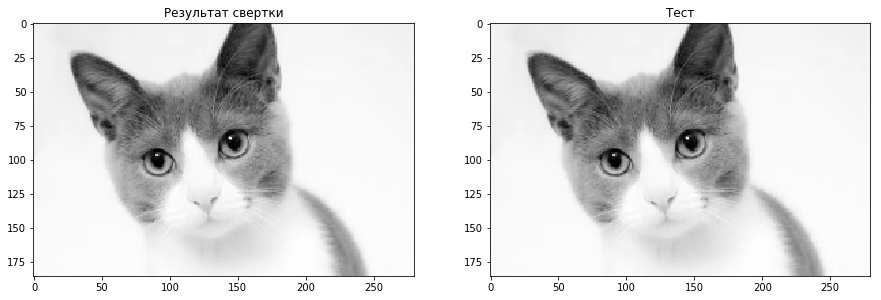

In [11]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2))
o_image /= 4 # усредняем
torch.save(o_image, './data/kernel_05.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_05.pth')
assert o_image.size() == torch.Size([186, 280]), 'Размер выходного изображения не совпадает с размером теста'
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 1, padding 1

torch.Size([372, 560])


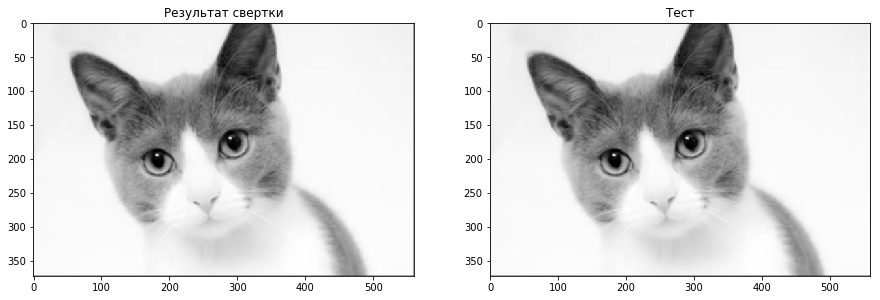

In [12]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(1,1), padding=(1,1))
o_image /= 4 # усредняем
#torch.save(o_image, './data/kernel_04.pth') # тут проверочный выход читанем его
test_conv(o_image, './data/kernel_04.pth')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 & 1 \\
    1 & 1 & 1 \\
    1 & 1 & 1
\end{bmatrix}$$

### и stride 2, padding 2

torch.Size([187, 281])


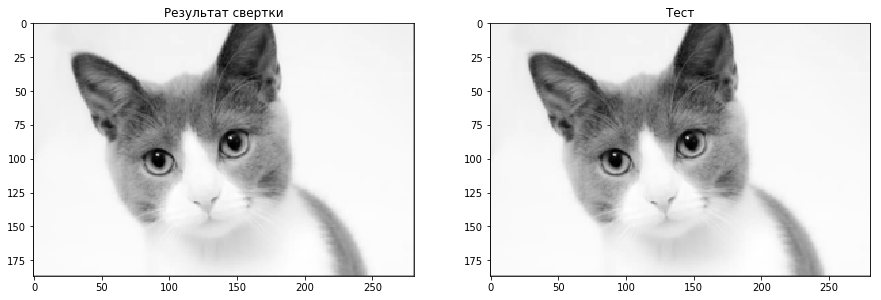

In [13]:
filter_kernelx2 = torch.FloatTensor(3,3,3).fill_(1)
o_image = my_conv2d(cat_tensor, filter_kernelx2, stride=(2,2), padding=(2,2))
o_image /= 4 # усредняем
test_conv(o_image, './data/kernel_06.pth')

### Ядро свертки с гаусовым распределением

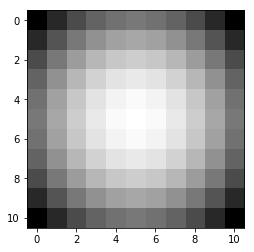

In [14]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем сверку 

torch.Size([362, 550])


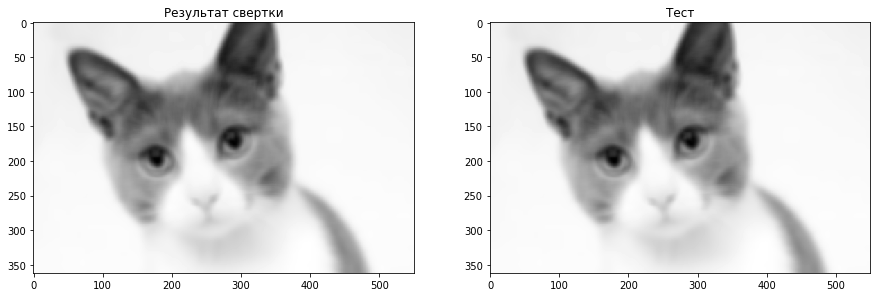

In [15]:
o_image = my_conv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0))
test_conv(o_image, './data/kernel_07.pth', False)

# Написать модуль батч нормализации для картинок
<img src="./imgs/37.png" width=400>

- Как выглядит формула финальной батч нормализации в слое при прямом проходе в процессе тренеровки сети, используем формулу для экспоненциального скользящего среднего:
$$
\large
\begin{align}
v_t = \beta \times v_{t-1} + (1-\beta)\times \mu_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ среднее \\ 
s_t = \beta \times s_{t-1} + (1-\beta)\times \sigma^2_t \leftarrow для \ каждой \ ФИЧИ \ в \ батче \ расчитываем \ ее \ дисперсию \\ \\
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - \mu}{ \sqrt{\sigma^2 + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя \ в \ режиме\ тренировки
\end{align}
$$

где $ \large \gamma, b $ - параметры, афинного преобразования, размерность - количество фичей во входном тензоре, эти параметры обучаются вместе с батч нормализацией

- Как выглядит правило для расчета выхода в процессе инференса:
$$
\large
\begin{align}
\hat{\mathbf{x}} = \frac{\mathbf{x_t} - v_t}{ \sqrt{s_t + \epsilon}} \times \gamma + b \leftarrow финальная \ формула \ для \ расчета  \ выхода\ слоя
\end{align}
$$

$\large s_t, v_t, \\ параметры считаются в процессе тренировки
\gamma, b $ - обучаемые параметры параметры.

### Задание:
Реализовать модуль 2d батч нормализации и проверить его работу на входных изображениях.

P.S. Каждый канал входной картинки считается отдельной фичёй (компонентом векторв)

Нужные функции
```python
import torch
torch.zeros - создать тензор заполненный нулями
torch.ones - создать тензор заполненный единицами
torch.Tensor - создать тензор(1, in_channels, 1, 1)
torch.mean, torch.var  - среднее и дисперсия
x.uniform_ - заполнить тензор случайными числами из равномерного распределения
y.expand_as(x) - расширить тензор y до размера x, по расширяемым направлениям размерность тензора x должна быть равна 1
x.unsqueeze(dim) - добавить размерность в тензор
x.squeeze - убрать размерность

```

In [142]:
import torch.nn as nn

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        """
         Инициализация BN
         Если задан флаг afine, то должны быть проинициализированны матрицы гамма и b
         для осуществления афинных преобразований в процессе тренировки и теста.
         Обучаемый параметры устанавливаем как тензора соответсвующей размерности и сохраняем 
         их 
         self.weight
         self.bias
         В данном ДЗ мы не обучаем эти параметры, лишь реализуем саму концепцию.
         
        :param in_channels: количество входных каналов предыдущего слоя
        :param afine: делать ли афинное преобразование в процессе обучения.
        :param beta: параметр сглаживания
        :param epsilon: параметр исключающий деление на ноль
        """
        super().__init__()
        
        self.weight = torch.ones(in_channels, 1, 1)
        self.bias = torch.zeros(in_channels, 1, 1)
        self.in_channels = in_channels
        self.afine = afine
        self.beta = beta
        self.epsilon = epsilon
        self.runing_mean = torch.zeros(in_channels)
        self.runing_var = torch.ones(in_channels)
        
        if afine:
            self.weight.uniform_()
        
    def forward(self, x):
        """
        Считаем параметры нормализации в режиме обучения, и нормализуем x в обоих режимах
        используем для расчета праметры gamma и b КАК обучаемые, т.е. учитываем, 
        что эти параметры должны быть обучены в процессе тренировки. 
        """
        if len(x.size()) < 4:
            x = x.unsqueeze(0)
        
        y = torch.transpose(x, 0, 1).view(self.in_channels, -1)
        mu = torch.mean(y, 1)
        var = torch.var(y, 1)
        
        if self.training:
           # находимся в режиме обучения
            self.runing_mean = self.beta * self.runing_mean + (1 - self.beta) * mu
            self.runing_var = self.beta * self.runing_var + (1 - self.beta) * var
            return (x - mu.view(1, self.in_channels, 1, 1).expand_as(x)) \
                    / (var.view(1, self.in_channels, 1, 1).expand_as(x) + self.epsilon) ** 0.5 \
                        * self.weight + self.bias
        
        
        return (x - self.runing_mean.view(1, self.in_channels, 1, 1).expand_as(x)) \
                / (self.runing_var.view(1, self.in_channels, 1, 1).expand_as(x) \
                   + self.epsilon) ** 0.5 * self.weight + self.bias

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


AssertionError: Что-то пошло не так, тест не пройден

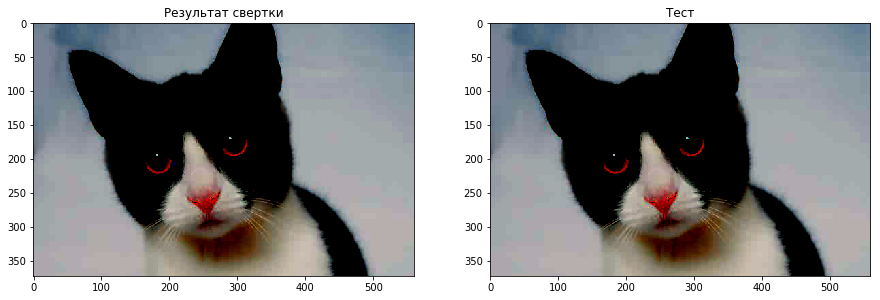

In [143]:
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_01.pth')

### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


AssertionError: Что-то пошло не так, тест не пройден

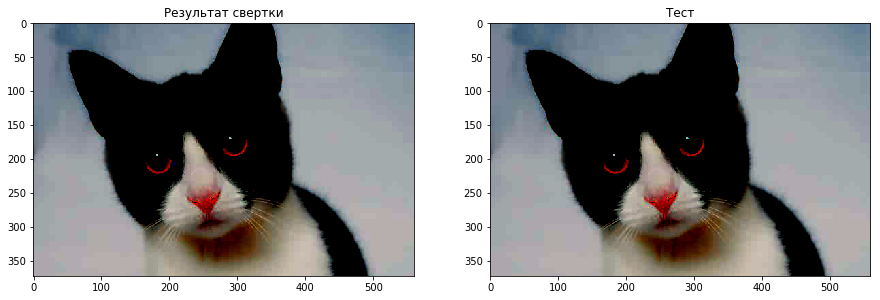

In [144]:
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_01.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([372, 560, 3])


AssertionError: Что-то пошло не так, тест не пройден

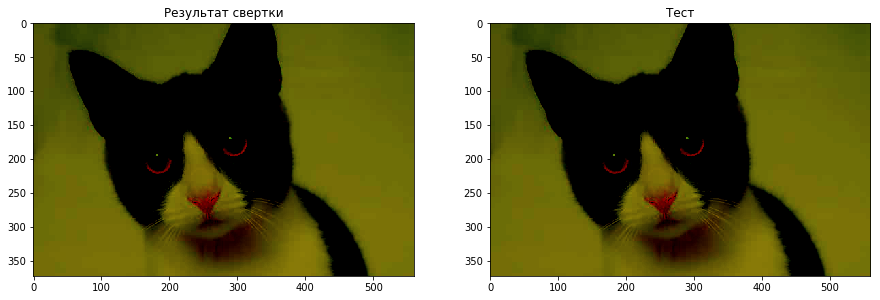

In [145]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
# Поэтому, чтобы получить детерменированный результат устанавливаем seed
torch.manual_seed(999)

bn = BatchNorm2d(3, afine=True)
assert bn.training # проверяем, что сеть находится в режиме тренировки
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
# транспонирование тензора картинки картинки
# для того, чтобы его мог отрисовать matplot
o_image = o_image.transpose(0,2).transpose(0,1)
test_conv(o_image, './data/bn_02.pth')
#print (o_image.size())

### Проверим как реализация работает на большом сете картинок
Цель проверить расчет running_mean and running_var, эти переменные мы расчитываем в режиме тренировки

In [83]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [84]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

/home/nullkatar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/nullkatar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 1, 28, 28)


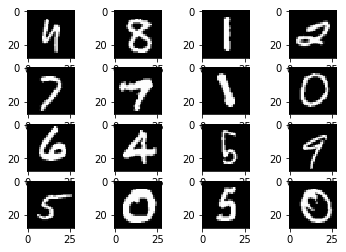

In [85]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются скользящее среднее значение в процессе тренировки

In [86]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    np.random.seed(999)
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ bn.runing_mean ] 
            var_curve +=  [ bn.runing_var ]
    return mean_curve, var_curve

In [146]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

BN beta=09


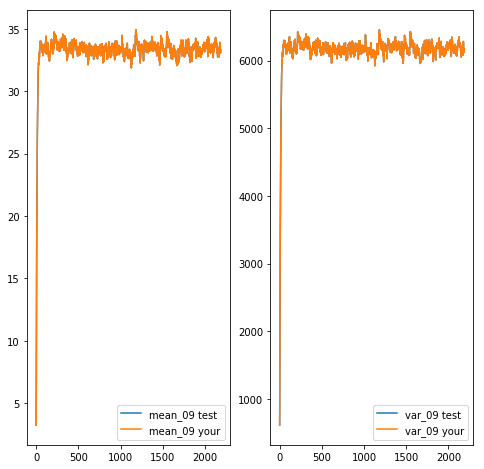

In [147]:
print ("BN beta=09")
test_bn_plots(mean_curve_09, var_curve_09, '09')

BN beta=099


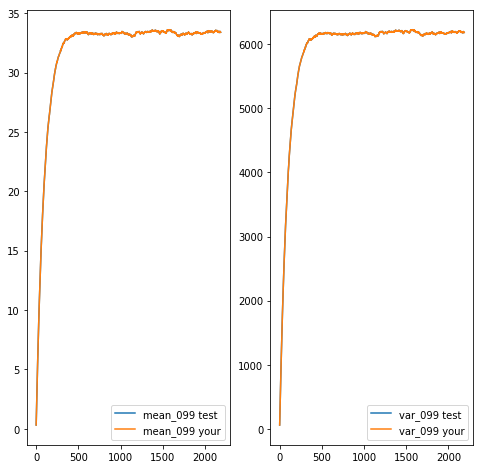

In [148]:
print ("BN beta=099")
test_bn_plots(mean_curve_099, var_curve_099, '099')

BN beta=05


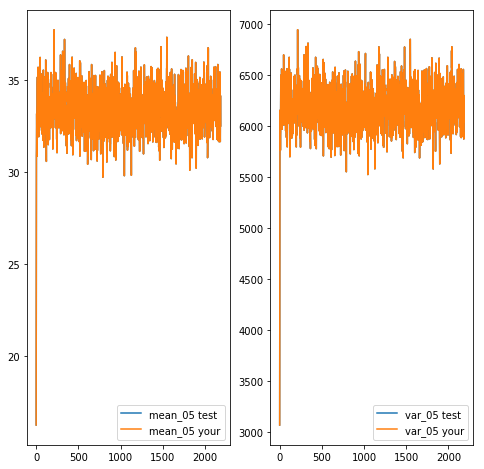

In [149]:
print ("BN beta=05")
test_bn_plots(mean_curve_05, var_curve_05, '05')

Смотрим какие значения средних и дисперсий у нас получились

In [ ]:
print ("Проверим, что правильно посчитали среднее и дисперсию при одинаковом seed")
assert int(bn_09.runing_mean[0]) == 33
assert int(bn_099.runing_mean[0]) == 33
assert int(bn_05.runing_mean[0]) == 32
assert int(bn_09.runing_var[0]) == 6136
assert int(bn_099.runing_var[0]) == 6180
assert int(bn_05.runing_var[0]) == 6038
print ('ok')

Посмотрим как повлияла батч нормализация на изображения

In [ ]:
n=4
bn = bn_09
bn.train(False) # эмулируем режим тренировки
np.random.seed(666)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    # загрузим сохраненный тестовый тензор 
    t_I = torch.load('./data/bn_minst_%2d.pth'%i)
    # проверим, что нормализованный и тестовый тензор совпадают 
    assert (I == t_I).all(), "Что-то не так нормализованный тензор через running_mean и running_var не совпадают"
    plt.imshow(I, cmap='gray')

## Done

# Реализуем свой Adam и SGD c моментом

Для реализации своего алгоритма оптимизации в pytorch нужно отнаслеловаться от базового класса Optimizer. При начальной инициализации алгоритма оптимизации он получает в качестве параматра все веса сети. Веса сети можно молучить через 
net.parameters(). По весам сети расчитывается градиент в функции loss.backward(). Веса сети организуются в группы, 
каждая группа образует словарь с сохраненными параметрами обучения, задаются в конструкторе, и самими параметрами, которые доступны по ключу "params". Параметры сети описываются классом Parameters. Для доступа к градиентам используется свойство grad.
Это тензор. Для сохранения параметров оптимизатор имеет свойство state, которое является словарем. Используется для
хранения промежуточных значений средних, дисперсий между шагами итераций.

**Задача** - реализовать функци step() для SGD и Adam, сравнить кривые обучения в зависимости от гиперпараметров (коэффициент обучения, betas), построить графики для различных параметров для каждого алгоритма, сделать выводы о скорости сходимости


## Adam (Adaptive Moment Estimation) 

Adam = SGD + Momentum + RMSProp

$$
\large
\begin{align}
m_t &= \alpha \ m_{t-1} + (1 - \alpha)\ g - момент \\ 
v_t &= \beta \ v_{t-1} +  (1-\beta)\ g_{t}^2  - скользящее\ среднее \ по \ квадрату \ градиента \\
\\
\hat{m_t} &= \frac{m_t}{1 - \alpha^t}\\
\hat{v_t} &= \frac{v_t}{1 - \beta^t}\\
\theta_t &= \theta_{t-1} -  \frac{\lambda}{\sqrt{\hat{v_t} + \epsilon}}\hat{m_t} \\
\ выразим\ step\_size \ через \ \alpha \ и \ \beta \\
\ step\_size =  \lambda \frac {({1 - \beta^t})^{\frac{1}{2}}}{{1 - \alpha^t}} \\ 
\theta_t &= \theta_{t-1} -  \frac{step\_size}{\sqrt{v_t + \epsilon}}\times m_t 
\end{align}
$$


In [19]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        """
        :param params: - параметры оптимизируемой сети
        :param betas: - коэффициенты сглаживания
        :param eps: - 
        """
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] 
            eps = group['eps']
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                        
                # запоминаем шаг
                state['step'] += 1

                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)
                
        return loss

## SGD + Momentum
$$
\Large
\begin{align}
g_t &= \nabla_{\theta} \overset{\wedge}{\large J}\left(x,y,\theta \right) - градиент \\
m_t &= \beta m_{t-1} - (1- \beta) g_t, \ где \  \beta - параметр\ обучения \\
m_t &= \alpha m_{t-1} - \lambda g_t, \ альтернативная \ форма \ записи \\
\theta_t &= \theta_{t-1} + m_t
\end{align}
$$

In [20]:
class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        """
        :param params: - параметры оптимизируемой сети
        :param beta: - коэффициент сглаживания
        :param eps: - 
        """        
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """
        Выполняем оптимизационный шаг
        """

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                d_p = p.grad.data
                
                if beta != 0:
                    param_state = self.state[p]
                    
                    if 'momentum' not in param_state:
                        buf = param_state['momentum'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum']
                        buf.mul_(beta).add_(1, d_p)

                p.data.add_(-group['lr'], d_p)


        return loss

Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [21]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [22]:
USE_CUDA=False

## Определение нашей модели
Параметры инициализации
- Без параметров - конволюции и активации
- dropout = True - c dropout
- batchnorm = True - включаем  batch normalization

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        # добавляем бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))            
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        # добавляем бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))
        # Линейный слой классификатора
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        return x

## Функция обучения модели

In [24]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss )
            loss.backward()
            optimizer.step()  
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [25]:
learning_rate = 1e-1 # 
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0)
loss_curve_sgd = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.11933032111369098
Do epoch 1 with loss 0.051359315370867444
Do epoch 2 with loss 0.04039599538994097
Do epoch 3 with loss 0.03416760827942313
Do epoch 4 with loss 0.029000491452342472
Do epoch 5 with loss 0.027226366719318735
Do epoch 6 with loss 0.024539010739784345
Do epoch 7 with loss 0.022166985492075096
Do epoch 8 with loss 0.020237822271287304
Do epoch 9 with loss 0.019057660003775706
Do epoch 10 with loss 0.017092641635495995
Do epoch 11 with loss 0.01532328873532081
Do epoch 12 with loss 0.015289063646769381
Do epoch 13 with loss 0.014064933683946354
Do epoch 14 with loss 0.014375702940033187
Do epoch 15 with loss 0.012953974115804935
Do epoch 16 with loss 0.012169298614112548
Do epoch 17 with loss 0.010735736186367004
Do epoch 18 with loss 0.009878602194006606
Do epoch 19 with loss 0.008975104304906925


## SGD с моментом

In [26]:
learning_rate = 1e-1
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.1205855561739705
Do epoch 1 with loss 0.053778497184527534
Do epoch 2 with loss 0.042157774148095836
Do epoch 3 with loss 0.036150130200969285
Do epoch 4 with loss 0.03076269411174031
Do epoch 5 with loss 0.02797894622358929
Do epoch 6 with loss 0.0253706012427071
Do epoch 7 with loss 0.022777338972580066
Do epoch 8 with loss 0.02105243554808094
Do epoch 9 with loss 0.018977124051492836
Do epoch 10 with loss 0.017882945800432617
Do epoch 11 with loss 0.016388018227599232
Do epoch 12 with loss 0.015067103645493029
Do epoch 13 with loss 0.013636374151973786
Do epoch 14 with loss 0.013176686816500048
Do epoch 15 with loss 0.011993627557484156
Do epoch 16 with loss 0.011494975300291983
Do epoch 17 with loss 0.00992059002442615
Do epoch 18 with loss 0.00983170051320154
Do epoch 19 with loss 0.00952122374776296


## Adam

In [27]:
learning_rate = 1e-3
net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam = fit_net(20, net, optimizer)

Do epoch 0 with loss 0.17854731842691515
Do epoch 1 with loss 0.0521715557103475
Do epoch 2 with loss 0.04119907955837721
Do epoch 3 with loss 0.03520622885890116
Do epoch 4 with loss 0.030900950751501163
Do epoch 5 with loss 0.026743731230551016
Do epoch 6 with loss 0.02478272647302637
Do epoch 7 with loss 0.02269361407630602
Do epoch 8 with loss 0.020120154612194737
Do epoch 9 with loss 0.01814845011943345
Do epoch 10 with loss 0.016799928958738112
Do epoch 11 with loss 0.01571678280841881
Do epoch 12 with loss 0.014347202895327578
Do epoch 13 with loss 0.013252737294976434
Do epoch 14 with loss 0.012087048592280544
Do epoch 15 with loss 0.010862213510822566
Do epoch 16 with loss 0.010876591998893619
Do epoch 17 with loss 0.010211804725899274
Do epoch 18 with loss 0.009035191415297761
Do epoch 19 with loss 0.008524717870858256


# Кривые обучения

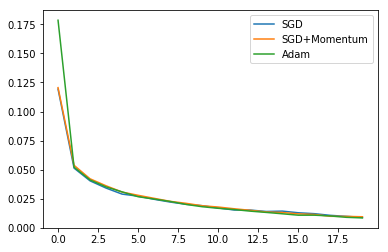

In [28]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.plot(loss_curve_sgd_momentum,label="SGD+Momentum")
ax.plot(loss_curve_adam, label='Adam' )
ax.legend()

### Выводы
Тут нужно написать выводы по сравнению скорости сходимлости алгоритмов SGD, SGD + Momentum, ADAM для различных праметров
1. lr - коэффициент обучения для всех элгоритмов (0.1, 0.01, 0.001, 0.0001) при фиксированных остальных гиперпараметрах 
2. beta - для SGD + momentum (0,9, 0,99, 0,5) для лучшего графика в пункте 1.
3. beta1, beta2 - для ADAM - для различных значений (0,9, 0,99, 0,5) для лучшего графика в пункте 1.

Для SGD скорость скходимотси максимальная при $lr=0.1$ 

Для SGD + momentum при $lr=0.1$ наилучшая скорость сходимости при $beta=0.5$ 

Для Adam при $lr=0.001$ наилучшая скорость сходимости при $beta1=0.9, beta2=0.99$